In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.ensemble import IsolationForest
#from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import validation_curve
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score
#from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier

#import pickle

In [2]:
colNames = list(range(1024))
colNames.append("label")
df = pd.read_csv('../qsar_oral_toxicity.csv', sep=';',names=colNames)

In [4]:
df

,0,1,2,3,4,5,6,7,8,9,...,1015,1016,1017,1018,1019,1020,1021,1022,1023,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,negative
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,negative
2,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,negative
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,negative
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8987,0,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,negative
8988,0,1,0,0,0,1,0,1,0,0,...,0,0,0,1,0,0,0,0,0,negative
8989,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,negative
8990,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,negative


In [5]:
df.shape

(8992, 1025)

In [6]:
#label 1 is positive; otherwise negative
df = pd.get_dummies(df)
df.drop("label_negative",1,inplace=True)
df = df.rename({"label_positive":"label"},axis=1)

In [7]:
df[df["label"]==1].shape
#according to paper's table, this means we have VT data, with ECFP_1024_02 or ECFP_1024_02R

(741, 1025)

In [8]:
df["label"].value_counts()

0    8251
1     741
Name: label, dtype: int64

In [22]:
#train, test split
train, test=train_test_split(df, test_size = 0.3, random_state=1)
train.reset_index(drop=True, inplace=True)

In [26]:
train["label"].value_counts()

0    6038
1     557
Name: label, dtype: int64

In [29]:
#!pip install imblearn

  Using cached imblearn-0.0-py2.py3-none-any.whl (1.9 kB)
  Using cached imbalanced_learn-0.8.0-py3-none-any.whl (206 kB)


In [30]:
#upsampling: https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets#t10
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=12, sampling_strategy=1)#'minority')
X_train, y_train = smote.fit_resample(train.drop(["label"],1), train["label"])

#plot_2d_space(X_train, y_train, 'SMOTE over-sampling')
X_test=test.drop(["label"],1)
y_test=test["label"]

In [31]:
y_train.value_counts()

0    6038
1    6038
Name: label, dtype: int64

In [32]:
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import plot_roc_curve
train["label"].value_counts()

0    6038
1     557
Name: label, dtype: int64

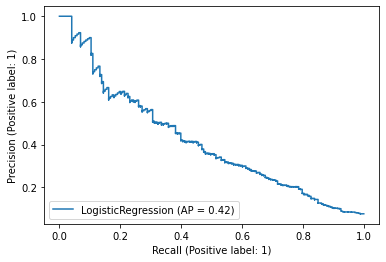

In [35]:
#log
log = LogisticRegression(max_iter=2000)
log.fit(X_train, y_train)
#print("weights:")
#for i in range(0, len(log.coef_[0])):
#    print("b{}: {}".format(i, log.coef_[0][i]))
#print("weights: {}".format(log.coef_[0]))
plot_precision_recall_curve(log, X_test, y_test)

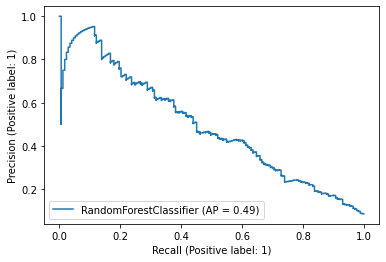

In [37]:
#forest; grid search 2 vars
classifier = RandomForestClassifier(n_estimators=50, random_state=0, max_depth = 15)
classifier.fit(X_train, y_train)
plot_precision_recall_curve(classifier, X_test, y_test)

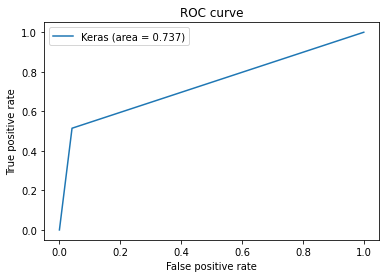

In [59]:
#grid search, inspiration: https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

#setting up NN model 
def setUpModel(lr=0.01):
    #set up and compile a model
    model = keras.Sequential()
    
    model.add(layers.Dense(13, input_dim=X_train.shape[1], activation="sigmoid"))
    model.add(layers.Dense(15, activation="sigmoid"))
    model.add(layers.Dense(1, activation="sigmoid")) #1 output layer bc of binary output
    
    model.compile(loss='mse',
         optimizer = keras.optimizers.SGD(momentum=0.99, learning_rate=lr),
         metrics=['accuracy',
             keras.metrics.Recall(name="recall", thresholds=0.3)
                 ])
        
    return model

#create a scikilearn-compatible model
Kmodel = KerasClassifier(build_fn=setUpModel, verbose=0, batch_size=40, epochs=100)
Kmodel.fit(X_train, y_train, epochs=40, batch_size=50, verbose=0)
from sklearn.metrics import roc_curve
y_pred_keras = Kmodel.predict(X_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test.reset_index(drop=True), y_pred_keras, pos_label=2$)
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)
#plot_precision_recall_curve(Kmodel, X_test, y_test)
plt.figure(1)
#plt.xlim(0, 0.2)
#plt.ylim(0.8, 1)
#plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [61]:
fpr_keras

array([0.        , 0.04144578, 1.        ])

In [60]:
y_pred_keras

array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)

In [44]:
Kmodel.predict_proba(X_test)

AttributeError: 'KerasClassifier' object has no attribute 'model'

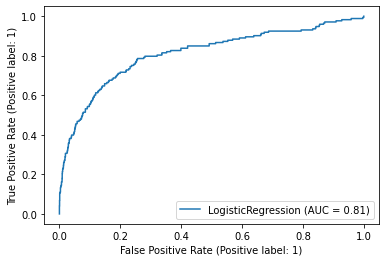

In [39]:
plot_roc_curve(log, X_test, y_test)

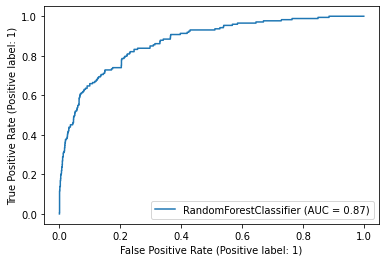

In [40]:
plot_roc_curve(classifier, X_test, y_test)

In [43]:
plot_roc_curve(Kmodel, X_test, y_test)

ValueError: KerasClassifier should be a binary classifier